# Control robotic vehicle using intelligent techiques of Machine Learning

# Έλεγχος Ρομποτικού οχήματος με ευφυείς τεχνικές Μηχανικής Μάθησης`

In [1]:
! pip install beautifultable

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from beautifultable import BeautifulTable

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import librosa.display

## Dataset preview

Dataset: [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license. These words are either:
<br/><br/> Words:
*   Basic Words: **Yes**, **No**, **Up**, **Down**, **Left**, **Right**, On, Off, **Stop**, **Go**, Zero, **One**, **Two**, **Three**, Four, Five, Six, Seven, Eight, and Nine.
*   Auxiliary Words: Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, and Wow.
*  Environment's noise: doing_the_dishes, dude_miaowing, exercise_bike, pink_noise, running_tap, and white_noise.

Location: `speech_commands_v0` folder in GoogleDrive

<br/> In bold have been marked the words that will be used for training. For proper memory managment the other words have been removed. As a result in `speech_commands_v0.01` are located samples of 11 selected words.


Check [Read Commands](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [3]:
# Connection with google colab in order to load dataset
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Change Direcotry and set dataset_dir as default
os.chdir('/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01')

In [5]:
!pwd

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [6]:
data_dir = os.getcwd()
print(data_dir)

/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01


In [7]:
## Check basic statistics about the dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print("Commands:", commands)

Commands: ['left' 'right' 'go' 'stop' 'yes' 'no' 'up' 'down' 'one' 'two' 'three'
 'four']


In [8]:
## Extract the audio files into a list and shuffle it.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)

Number of total examples: 28462


In [9]:
## Preview dataset 
table = BeautifulTable()
table.column_headers = ["", "Samples"]
for command in commands:
  table.append_row([command,  len(tf.io.gfile.listdir(data_dir+'/'+str(command)))])

table.append_row(['TOTAL',num_samples])
print(table)

/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


+-------+---------+
|       | Samples |
+-------+---------+
| left  |  2354   |
+-------+---------+
| right |  2373   |
+-------+---------+
|  go   |  2372   |
+-------+---------+
| stop  |  2381   |
+-------+---------+
|  yes  |  2377   |
+-------+---------+
|  no   |  2375   |
+-------+---------+
|  up   |  2379   |
+-------+---------+
| down  |  2359   |
+-------+---------+
|  one  |  2371   |
+-------+---------+
|  two  |  2383   |
+-------+---------+
| three |  2366   |
+-------+---------+
| four  |  2372   |
+-------+---------+
| TOTAL |  28462  |
+-------+---------+


As we see, dataset is balacned. The samples of each label are almost equal.

### Split Dataset

In [10]:
def split_dataset(dataset, train_size):
  
  #Reminder: Dataset has already been shuffled
  num_samples = len(dataset)
  train_samples= round(train_size * num_samples)

  train_fs = dataset[:train_samples]
  test_fs = dataset[train_samples:]

  return train_fs,test_fs

In [11]:
# We define (%) of test and val dataset 
test_size = 0.1
val_size = 0.1

# Train - Test split 
train_files, test_files = split_dataset(filenames, 1-test_size)
# Train - Val split 
train_files, val_files = split_dataset(train_files, 1 - val_size/(1-test_size))


In [12]:
table = BeautifulTable()
table.column_headers = ["", "Samples", "Size(%)"]

table.append_row(['train',len(train_files),(1 - val_size - test_size)*100])
table.append_row(['val',len(val_files),val_size*100])
table.append_row(['test',len(test_files),test_size*100])

print(table)
print("Total Samples:",num_samples)

+-------+---------+---------+
|       | Samples | Size(%) |
+-------+---------+---------+
| train |  22770  |  80.0   |
+-------+---------+---------+
|  val  |  2846   |  10.0   |
+-------+---------+---------+
| test  |  2846   |  10.0   |
+-------+---------+---------+
Total Samples: 28462


/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


## Read audio files - Future Extraction

In this step we read audio files using `tf.audio.decode_wav` that converts them into numerical tensors.  Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that this function will normalize the values to the range [-1.0, 1.0].

In [13]:
# Example:
audio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")
audio, f = tf.audio.decode_wav(audio_binary)
a = tf.squeeze(audio, axis=-1)
print(a.numpy())

[ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
 -0.00054932]


In [14]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)

  '''
  audio = tf.Tensor(
  [[ 0.00057983]
  [ 0.00076294]
  [ 0.00100708]
  ...
  [-0.00085449]
  [-0.00067139]
  [-0.00054932]], shape=(16000, 1), dtype=float32)
  '''
  return tf.squeeze(audio, axis=-1)

  '''
  tf.Tensor(
  [ 0.00057983  0.00076294  0.00100708 ... -0.00085449 -0.00067139
    -0.00054932], shape=(16000,), dtype=float32)

  '''

The label for each WAV file is its parent directory.

In [15]:
def get_label(file_path):
  #  Reminder:
  ## filepath: "MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav"
  parts = tf.strings.split(file_path, os.path.sep)
  
  #So parts[-2] returns in this example: "three"
  return parts[-2]

Define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Why we use 
```Dataset.from_tensor_slices()``` :

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

*   Create a source dataset from your input data.
*   Apply dataset transformations to preprocess the data.
*   Iterate over the dataset and process the elements.

Iteration happens in a **streaming fashion**, so the full dataset does not need to fit into memory

In [17]:
AUTOTUNE = tf.data.AUTOTUNE                                                     # The number of parallel calls is set dynamically based on available CPU

files_ds = tf.data.Dataset.from_tensor_slices(train_files)                      # Convert each sample to "tf.Tensor(b'/content/drive/MyDrive/Thesis_George_Giannios/speech_commands_v0.01/three/8c3c4715_nohash_2.wav', shape=(), dtype=string)"
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE) # Applying transformation to  to seperate labels and wav files

In [18]:
# Now we want to find unique labels and plot audio's amplitude along time
total_commands = len(commands)
print("Total Commands are", total_commands)

Total Commands are 12


### Time Domain

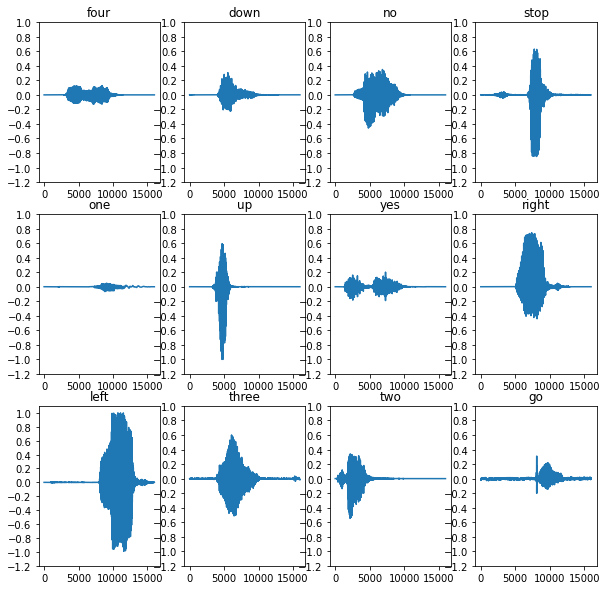

In [19]:
# Now we want to find unique labels and plot audio's amplitude along time.

## Create grid for plotting 
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

## Initialize seen labels in order to "extract" unique ones
seen_labels = [] 
i = 0;

# We will search for unique labels in 50 out of 26000 samples
search_samples = 50

## Search for unique labels and plot them into grid
for (audio, label) in waveform_ds.take(search_samples):
  
  if label not in seen_labels:

    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    #Convert tensor to numpy 
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

    if len(seen_labels) == total_commands:
      break;

    seen_labels.append(label)
    i = i + 1 ; 

plt.show()

### Frequency Domain 

Source: [
FFT with Python](https://github.com/balzer82/FFT-Python/blob/master/FFT-Tutorial.ipynb). 
<br/>Using hamming window, for avoiding Leakage Effect (remember Fourier Transform was originally invented by Mr Fourier for, and only for, periodic signals). The signal has to be strictly periodic, which introduces the so called windowing to eliminate the leakage effect.



(16000,)


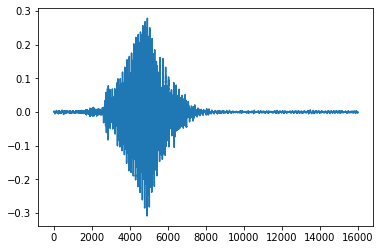

In [20]:
# Example: Plotting a simple audio signal along time
audio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")
audio, f = tf.audio.decode_wav(audio_binary)
time_domain = tf.squeeze(audio, axis=-1)
print(time_domain.numpy().shape)

plt.plot(time_domain.numpy())
plt.show()

In [21]:
def get_fft (waveform):
  hann = np.hanning(len(waveform))
  
  Y = np.fft.fft(hann*waveform)
  N = int(len(Y)/2+1)

  dt = 1
  fa = 16000.0/dt # scan frequency
  #print('dt=%.5fs (Sample Time)' % dt)
  #print('fa=%.2fHz (Frequency)' % fa)

  X = np.linspace(0, fa/2, N, endpoint=True)

  #plt.plot(X, 2.0*np.abs(Y[:N])/N)
  #plt.xlabel('Frequency ($Hz$)')
  #plt.ylabel('Amplitude ($Unit$)')

  return X, 2.0*np.abs(Y[:N])/N

In [22]:
# Example:
"""
audio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")
audio, f = tf.audio.decode_wav(audio_binary)
time_domain = tf.squeeze(audio, axis=-1)
get_fft(time_domain)

"""

'\naudio_binary = tf.io.read_file("three/8c3c4715_nohash_2.wav")\naudio, f = tf.audio.decode_wav(audio_binary)\ntime_domain = tf.squeeze(audio, axis=-1)\nget_fft(time_domain)\n\n'

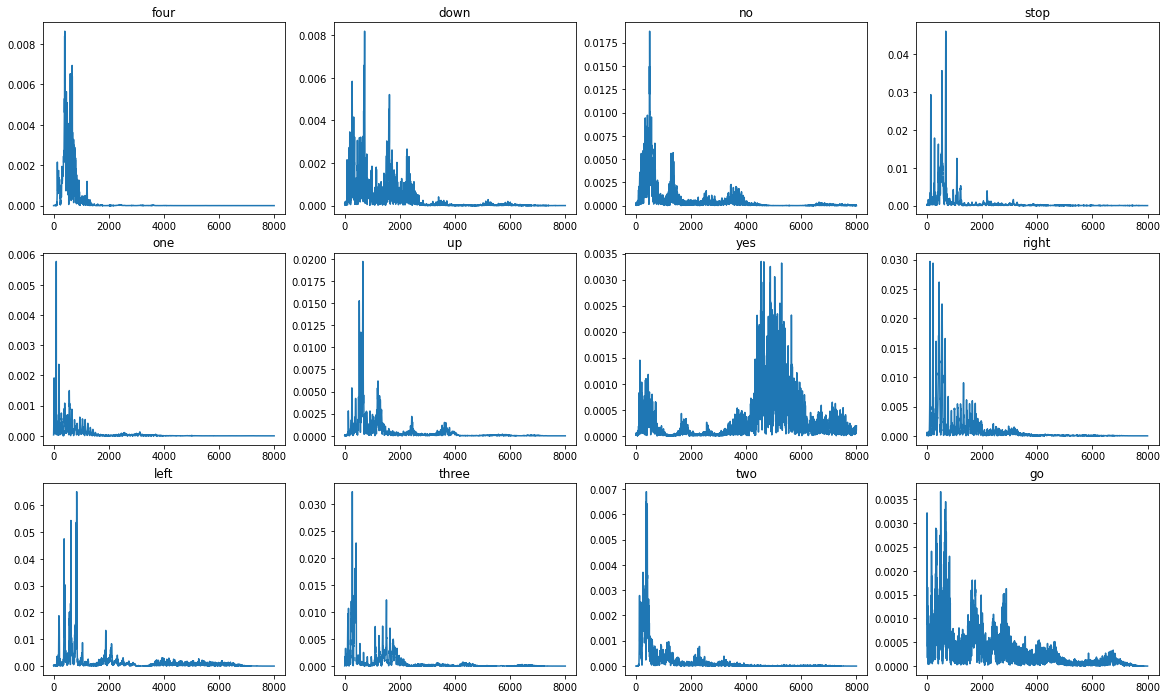

In [23]:
# Now we want to find unique labels and plot audio's amplitude along time.

## Create grid for plotting 
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

## Initialize seen labels in order to "extract" unique ones
seen_labels = [] 
i = 0;

# We will search for unique labels in 50 out of 26000 samples
search_samples = 50

## Search for unique labels and plot them into grid
for (audio, label) in waveform_ds.take(search_samples):
  
  if label not in seen_labels:

    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    #Convert tensor to numpy 
    
    f, magn = get_fft(audio.numpy())
    ax.plot(f,magn)
    
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

    if len(seen_labels) == total_commands:
      break;

    seen_labels.append(label)
    i = i + 1 ; 

plt.show()

### Spectrogram Convertion

Spectrogram shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain

In [24]:
#We count how many audio files need zero padding

'''
need_zero_pad = 0
for audio,_ in waveform_ds:
  if audio.numpy().shape[0] != 16000:
    need_zero_pad = need_zero_pad +1

print(need_zero_pad)

2251 / 28462 files need zero padding --> 0.08 % 
'''

'\nneed_zero_pad = 0\nfor audio,_ in waveform_ds:\n  if audio.numpy().shape[0] != 16000:\n    need_zero_pad = need_zero_pad +1\n\nprint(need_zero_pad)\n\n2251 / 28462 files need zero padding --> 0.08 % \n'

In [25]:
def get_spectrogram(waveform):
  
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  
  # The STFT (tf.signal.stft) splits the signal into windows of time 
  # and runs a Fourier transform on each window
  
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  
  ## 16000 / 128 = 125 windows

  # STFT produces an array of complex numbers representing magnitude and phase. 
  # However, we need only  the magnitude 
  
  spectrogram = tf.abs(spectrogram)

  ## want to replace zero values with something else:

  spectrogram = tf.where(spectrogram > 0, spectrogram, 10**(-2))

  ## 

  return spectrogram

In [26]:
'''
import numpy as np
np.random.seed(0)

prob = np.random.randint(5, size=4) /4
print(prob)

result = np.where(prob > 0.0000000001, prob, -10)
print(result)
np.log(result, out=result, where=result > 0)
print(result)
print("hello",np.log(10**(-100)))
'''

'\nimport numpy as np\nnp.random.seed(0)\n\nprob = np.random.randint(5, size=4) /4\nprint(prob)\n\nresult = np.where(prob > 0.0000000001, prob, -10)\nprint(result)\nnp.log(result, out=result, where=result > 0)\nprint(result)\nprint("hello",np.log(10**(-100)))\n'

In [27]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: four
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


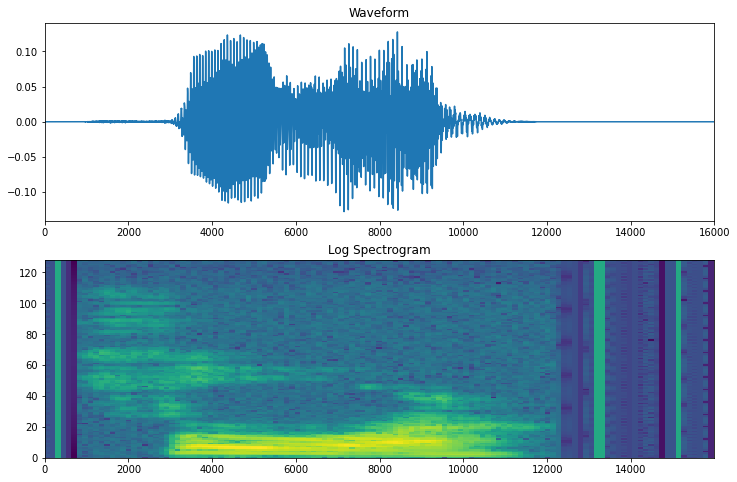

In [28]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  # log_spec.shape is (129,124)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Log Spectrogram')
plt.show()

In [29]:
# Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [30]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [31]:

seen_labels = np.zeros(total_commands,dtype = int)
print(seen_labels)

[0 0 0 0 0 0 0 0 0 0 0 0]


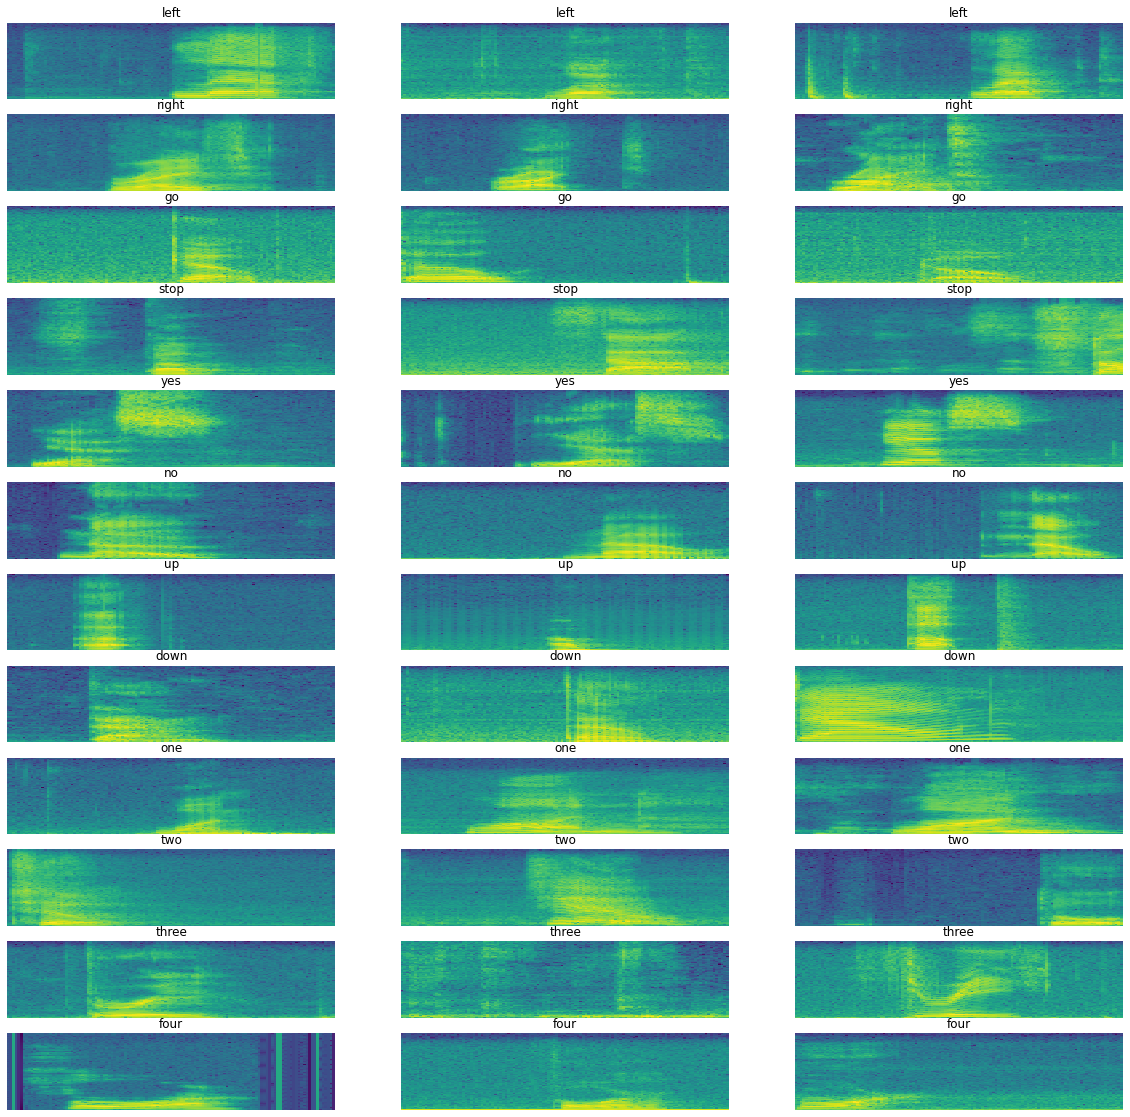

In [32]:
rows = total_commands
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))


# Search in 100 samples 
for (spectrogram, label_id) in spectrogram_ds.take(100):
  id = label_id.numpy()
  if (seen_labels[id] <= 2):
    ax = axes[id][seen_labels[id]]
    seen_labels[id] = seen_labels[id] + 1 
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

### MFCC (to_do)

## Dara pre-processing

In [33]:
## Repeat the training set preprocessing on the validation and test sets.
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [34]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [35]:
## Batch the training and validation sets for model training.
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

## Reduce read latency while training the model.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [36]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


## Build and train the models

### Model 1 (Simple CNN)

`Resizing layer`:downsample the input to enable the model to train faster. <br/>
`Normalization layer`: normalize each pixel in the image based on its mean and standard deviation

In [37]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
#About 45 minutes
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [39]:
EPOCHS = 3
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/3
356/356 [==============================] - 426s 1s/step - loss: 1.9751 - accuracy: 0.3413 - val_loss: 0.8298 - val_accuracy: 0.7586
Epoch 2/3
356/356 [==============================] - 2s 6ms/step - loss: 0.9408 - accuracy: 0.6938 - val_loss: 0.5807 - val_accuracy: 0.8261
Epoch 3/3
356/356 [==============================] - 2s 6ms/step - loss: 0.6832 - accuracy: 0.7750 - val_loss: 0.4928 - val_accuracy: 0.8472


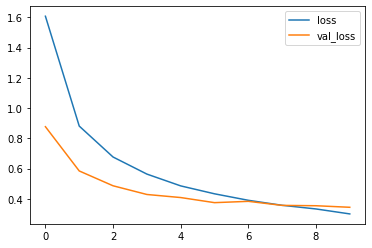

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Evaluate model

In [40]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [41]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


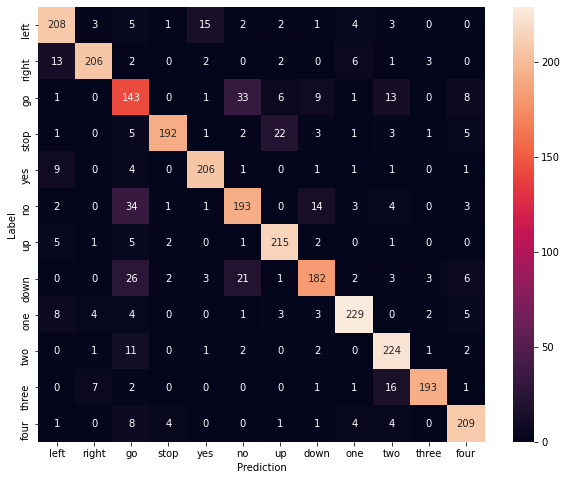

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Tensor("args_1:0", shape=(), dtype=string)


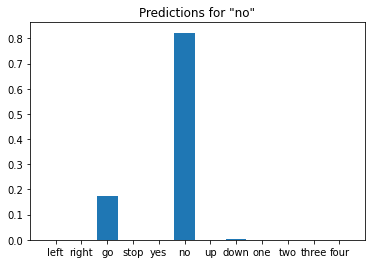

In [ ]:
sample_file = data_dir+'/no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


#### Save model

In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/models/simple_cnn'
os.mkdir(path)

model.save(path) 

In [ ]:
#!mkdir -p saved_model

In [ ]:
#model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
new_model = tf.keras.models.load_model(path)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

### Model 2 (Simple RNN to do)

#### Evaluate Model 2

### Model 3 (Transfer Learning) 

In [ ]:
def init_RESNET_model(summary):
  
  resnet_model=tf.keras.applications.ResNet50(input_shape=spectrogram.shape, include_top=False,weights = None)
  
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  # unfreeze conv layers
  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(12,activation='softmax')
  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model



In [ ]:
transfer_learning_model = init_RESNET_model(True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 5, 2048)        23581440  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 23,606,028
Trainable params: 23,552,908
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
transfer_learning_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
# 1 30 hour per epoch
EPOCHS = 1
history = transfer_learning_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

356/356 [==============================] - 5101s 14s/step - loss: 2.5929 - accuracy: 0.2350 - val_loss: 1.0244 - val_accuracy: 0.6753


#### Evaluate model

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(transfer_learning_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 69%


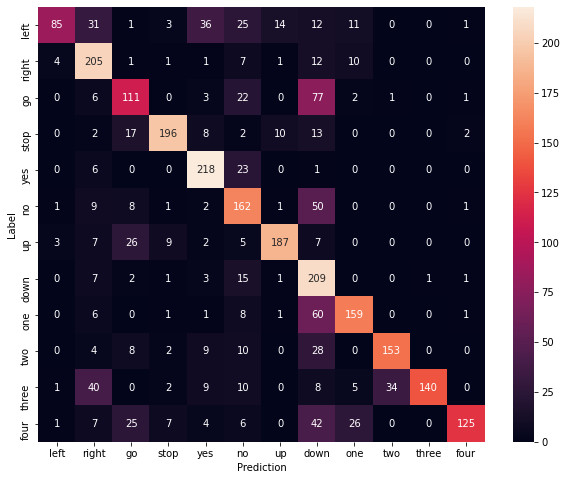

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


#### Save model

In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/models/simple_resnet'

os.mkdir(path)
transfer_learning_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/simple_resnet/assets


#### Continue Learning

In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/models/resnet_3ep'
new_model = tf.keras.models.load_model(path)

In [ ]:
# Continue learning process:
EPOCHS = 5
history = new_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
356/356 [==============================] - 3528s 10s/step - loss: 0.2243 - accuracy: 0.9279 - val_loss: 7.5879 - val_accuracy: 0.6103
Epoch 2/5
356/356 [==============================] - 122s 341ms/step - loss: 0.1589 - accuracy: 0.9488 - val_loss: 0.2904 - val_accuracy: 0.9125
Epoch 3/5
356/356 [==============================] - 122s 344ms/step - loss: 0.1225 - accuracy: 0.9594 - val_loss: 0.5207 - val_accuracy: 0.8742
Epoch 4/5
356/356 [==============================] - 123s 345ms/step - loss: 0.1219 - accuracy: 0.9598 - val_loss: 0.3097 - val_accuracy: 0.9164
Epoch 00004: early stopping


In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(new_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


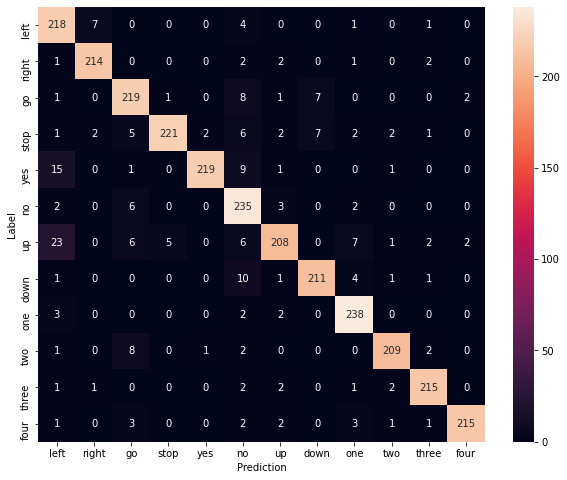

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Thesis_George_Giannios/models/resnet_8ep'

os.mkdir(path)
new_model.save(path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis_George_Giannios/models/resnet_8ep/assets
